# Introduction

In the binary VO<sub>2</sub> - Nb<sub>2</sub>O<sub>3</sub> system, VO<sub>2</sub> undergoes a transformation from monoclinic to tetragonal at varying alloying compositions and temperatures.

Using X-ray diffraction data for VO<sub>2</sub> - Nb<sub>2</sub>O<sub>3</sub> alloys collected at various at%V and temperatures, the phase regions of this system may be identified. This report uses clustering of XRD data to replicate a human-expert generated phase diagram of this system.

# 1.0 Data Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Load V compositions and temperature data
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
v_compositions = pd.read_csv('VO2 - Nb2O3 Composition and temp Combiview.txt', sep='\t', header=0)

# Load XRD vs 2*theta data
xrd_intensities = pd.read_csv('VO2 -Nb2O3 XRD Combiview.txt', sep='\t', header=0)

# Merge composition and temperature data with XRD intensities
raw_data = pd.concat([v_compositions,xrd_intensities,], axis=1)

In [3]:
# Drop rows containing NaN values
data = raw_data
data = data.dropna()
# Drop duplicated rows
data = data.drop_duplicates()

There are no missing values or duplicated rows in the data

# 2.0 Data Exploration

### 2.1 Generating a composition versus temperature plot

Text(0, 0.5, 'at% V')

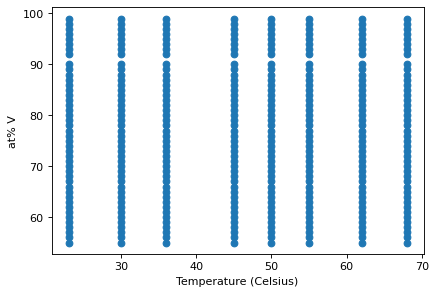

In [4]:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
from matplotlib.pyplot import figure
figure(figsize=(6,4), dpi=80)
plt.scatter(data['temp'],data['V'])
plt.xlabel("Temperature (Celsius)")
plt.ylabel("at% V")

### 2.2 Generating an XRD vs temperature plot for a  V composition of 99 at.%

In [5]:
# Retrieving XRD data for 99at.%V
v99_data = data[data['V'] == 99]

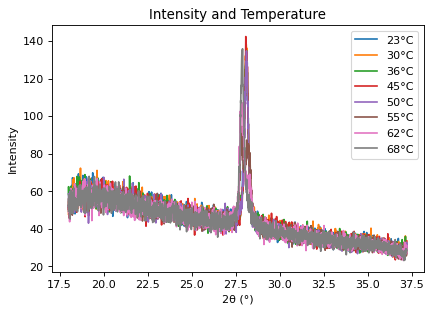

In [6]:
# Retrieve 2theta measurements to plot as x values
two_theta_angles = [float(two_theta) for two_theta in v99_data.columns[2:]]
figure(figsize=(6,4), dpi=80)
# Plot XRD vs. 2theta for each temperature
legend = []
for i in range(v99_data.shape[0]):
    plt.plot(two_theta_angles,v99_data.iloc[i][2:], markersize=0.00000001)

    legend.append(str(v99_data['temp'].iloc[i]) + "°C")
plt.title("Intensity and Temperature")
plt.xlabel("2θ (°)")
plt.ylabel("Intensity")
plt.legend(legend)
plt.show()

### 2.3 Generating an XRD vs composition plots for a constant temperature of 23

In [7]:
temp23_data = data[data['temp'] == 23]

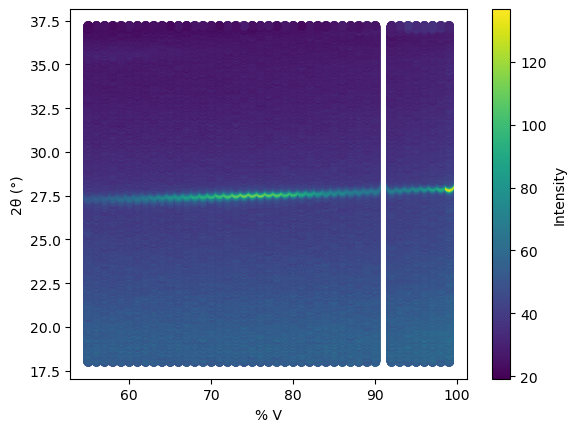

In [8]:
testdata = temp23_data
testdata = testdata.drop(['temp'], axis=1)

# Convert dataframe to (x, y, z) = (V%, 2theta, XRD intensity) form
# Learnt melt from:https://pandas.pydata.org/docs/reference/api/pandas.melt.html
testdata = testdata.melt(id_vars='V')
testdata.columns = ["V", "TwoTheta", "Intensity"]

# Converting 2theta values to float array to correct "too many ticks" problem in matplotlib
# https://numpy.org/doc/stable/reference/generated/numpy.ndarray.astype.html
# https://matplotlib.org/stable/gallery/ticks/ticks_too_many.html
Y = np.asarray(testdata['TwoTheta']).astype(float)
plt.scatter(testdata['V'], Y, c=testdata['Intensity'])
plt.xlabel("% V")
plt.ylabel("2θ (°)")

# Learnt how to label colorbar from
# https://matplotlib.org/stable/gallery/shapes_and_collections/ellipse_collection.html#sphx-glr-gallery-shapes-and-collections-ellipse-collection-py
plt.colorbar().set_label('Intensity')
plt.show()
# plt.pcolormesh(testdata['V'], testdata['TwoTheta'], testdata['Intensity'])

# 3.0 Dimensionality Reduction

## 3.1 Conducting Principal Component Analysis (PCA) on diffraction data

In [9]:
# Standardizing data for PCA analysis
from sklearn.preprocessing import StandardScaler
reduced_data = data.to_numpy()
std = StandardScaler()
std.fit(reduced_data)
reduced_data = std.transform(reduced_data)

Text(0, 0.5, 'PCA 2')

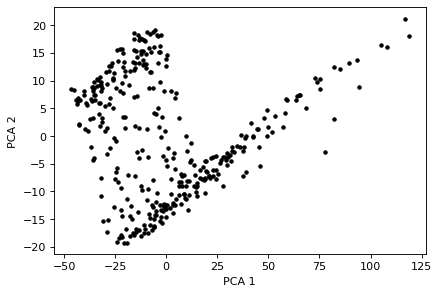

In [10]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA

# Set number of PCA components equal to the number 2theta angles
n_components = min(len(reduced_data[:,0]), len(reduced_data[0,:]))

pca = PCA(n_components)
pca.fit(reduced_data)
loading_vectors = pca.components_
explained_variance = pca.explained_variance_ 
pos = pca.transform(reduced_data)

# Visualize diffraction data on the first two principal components
figure(figsize=(6,4), dpi=80)
# plt.figure(4, figsize=(8,6))
plt.plot(pos[:,0], pos[:,1],'k.')
# pos = pos[:,:5]
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

## 3.2 Dropping noise from data

### 3.1 Creating a Scree plot to determine the number of components to retain from PCA

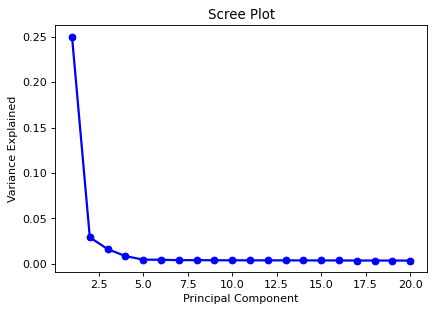

In [11]:
PC_values = np.arange(pca.n_components_) + 1
figure(figsize=(6,4), dpi=80)
plt.plot(PC_values[0:20], pca.explained_variance_ratio_[0:20], 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

It appears that <10 principal components explain the variance of the data; additional components do not provide further information. Before dropping the remaning components, the total variance explained by these 10 components must first be considered:

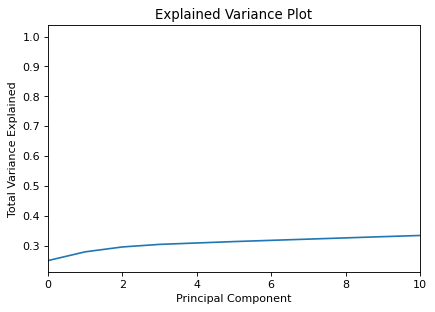

In [12]:
# Creating total variance explained plot
PC_values = np.arange(pca.n_components_) + 1
figure(figsize=(6,4), dpi=80)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance Plot')
plt.xlabel('Principal Component')
plt.ylabel('Total Variance Explained')
plt.xlim(0,10)
plt.show()

Less than half of the total variance is explained by the first five components

## 4.0 Plotting diffraction patterns in reduced dimensional space

Text(0.5, 1.0, 'Diffraction patten plotted by temperature')

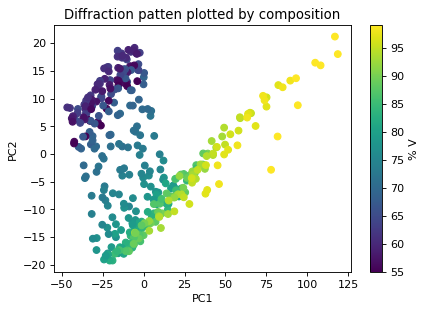

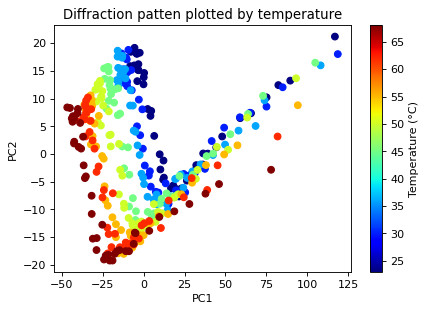

In [13]:

figure(figsize=(6,4), dpi=80)
plt.scatter(pos[:,0],pos[:,1], c = data['V'])
plt.colorbar().set_label("% V")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Diffraction patten plotted by composition")

figure(figsize=(6,4), dpi=80)
plt.scatter(pos[:,0],pos[:,1], c = data['temp'], cmap='jet')
plt.colorbar().set_label("Temperature (°C)")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Diffraction patten plotted by temperature")

# 5.0 XRD clustering analysis

### 5.1 Conducting inertia analysis to determine optimal  number of clusters

C:\Users\karth\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


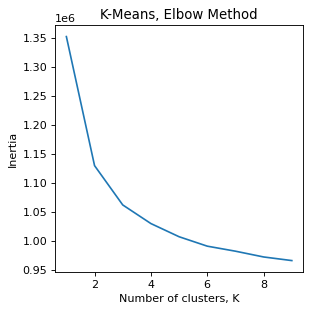

In [14]:
from sklearn.cluster import KMeans

inertias = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pos)
    inertias[k] = kmeans.inertia_ 

figure(figsize=(4,4), dpi=80)
plt.plot(list(inertias.keys()), list(inertias.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Inertia");

A cluster size of k = 3 appears to be optimal. This also matches the amount of phase regions identified by  human experts -- and so 3 clusters will be used.

### 5.2 Conducting clustering

Text(0, 0.5, 'PC2')

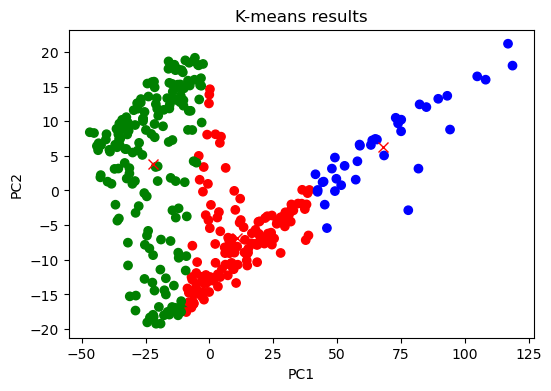

In [15]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, random_state = 0).fit(pos)
L = list(kmeans.labels_)
# assign colours to the labels
clist = ['r','g','b','k','c','m','y'] # for up to 7 colors
for cl in range(k):
    L = [clist[cl] if i==cl else i for i in L]
    
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize = (6,4))
plt.scatter(pos[:,0],pos[:,1],c = L)
plt.plot(cluster_centers[:,0], cluster_centers[:,1], 'rx', markersize=7)
plt.title('K-means results')
plt.xlabel('PC1')
plt.ylabel('PC2')

In [16]:
# Append list cluster labels, L, to XRD data
data["Cluster"] = pd.DataFrame(L)

### 5.3 Phase diagram construction from clustering

Text(0.5, -0.05, 'Each color represents a different phase field')

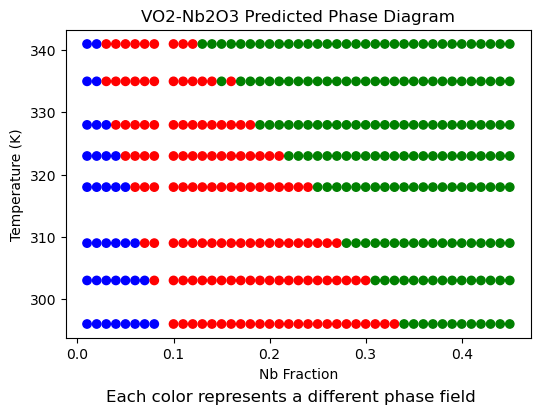

In [17]:
# Convert data to Nb fraction 
comp_Nb = 1 - (data['V'] / 100)

# Convert temperature to Kelvin to match human-calculated phase diagram
temp_kelvin = data['temp'] + 273

plt.figure(figsize = (6,4))
plt.scatter(comp_Nb, temp_kelvin, c = data['Cluster'])
plt.xlabel("Nb Fraction")
plt.ylabel("Temperature (K)")
plt.title("VO2-Nb2O3 Predicted Phase Diagram")

# Learnt how to add caption from:
# https://stackoverflow.com/questions/34010205/adding-caption-below-x-axis-for-a-scatter-plot-using-matplotlib
txt = "Each color represents a different phase field"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)

# 6.0 Summary

The predicted phase diagram generally agrees with the phase diagram produced by human experts. However, the monoclinic (blue) phase region extends to a higher temperature in the predicted phase diagram than in the human-labelled phase diagram; furthermore, the compositional ranges of the predicted phase diagrams are also larger. Overall, PCA appears to be an acceptable method to distinguish datapoints in the original dataset. However, the low proportion of total variance explained by the first two principal components, and the lack of well-defined clusters in the graph of PC 1 vs PC 2 in Section 5.2, suggests that much remains to be improved.

Visualizing the data set revealed two key insights:
1. Only a very range of 2θ values, approximately near 27.5°, appear to be features that are useful for differentiating between of samples containing different % V. This is evident from the graph of Intensity vs. Composition in Section 2.3, where similar XRD intensity values are reported for all 2θ, for all samples, except near 27.5°.

2. PC1 and PC2 appear to more significantly distinguish (i.e. separate) data points based on temperature, compared to % V (Section  4.0 graphs). This is because the graph of PC1 vs PC2 and temperature has data points of the same color (i.e., same temperature XRD samples) that are spread both vertically and horizontally on other graph, whereas the same spreads are not as significant in the PC1 vs PC2 and %V graph.

A material archetype that may be contained within these K-means clusters is the 2θ values near 27.5° for each sample, as samples only exhibit significant differences in XRD intensity close to this angle. This would explain how despite the graph of PC 1 vs PC 2 (5.2) not having distinct, separate clusters, K-means produced three clusters that match well with human-labelled phases of the system. This might correspond to the crystal structure of each sample.